In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb

#visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Increase default plot size
from pylab import rcParams
rcParams['figure.figsize'] = (6, 5)

#warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#load dataset
og_train_df = pd.read_csv('titanic-dataset/train.csv')
og_test_df = pd.read_csv('titanic-dataset/test.csv')

og_train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [37]:
#look into data type
og_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Embarked       891 non-null object
Family_size    891 non-null int64
Title          891 non-null object
Fare_bin       891 non-null category
dtypes: category(1), float64(2), int64(5), object(3)
memory usage: 70.8+ KB


## 1. Data-Preprocessing

In [4]:
full_dataset = [og_train_df, og_test_df]

In [5]:
#inspect missing values
def frame_missing(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = total/df.shape[0]*100
    miss_df =  pd.concat([total, percent], axis=1)
    return miss_df

miss_train = frame_missing(og_train_df)
miss_train.columns = ["train - total nan", "train - % nan"]

miss_test = frame_missing(og_test_df)
miss_test.columns = ["test - total nan", "test - % nan"]

pd.concat([miss_train, miss_test], axis=1)

,train - total nan,train - % nan,test - total nan,test - % nan
Age,177,19.865320,86.0,20.574163
Cabin,687,77.104377,327.0,78.229665
Embarked,2,0.224467,0.0,0.000000
Fare,0,0.000000,1.0,0.239234
Name,0,0.000000,0.0,0.000000
Parch,0,0.000000,0.0,0.000000
PassengerId,0,0.000000,0.0,0.000000
Pclass,0,0.000000,0.0,0.000000
Sex,0,0.000000,0.0,0.000000
SibSp,0,0.000000,0.0,0.000000


In [6]:
#fill missing embarked values - train df
og_train_df.Embarked.fillna(value='C', inplace=True)
og_train_df.Embarked.isnull().sum()

0

In [7]:
#inspect mising value in test dataset's Fare
og_test_df[og_test_df.Fare.isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [8]:
#looking at the distribution, the sir is morelikely to pay:
mean = og_train_df[(og_train_df.Embarked=='S')&(og_train_df.Pclass==3)].Fare.mean()
print("Mean Fare for 3rd SocioClass coming from SouthHampton: USD", mean)

#fillna
og_test_df.Fare.fillna(mean, inplace=True)
print("Check if fillna works, number of null in Fare:", og_test_df.Fare.isnull().sum())

Mean Fare for 3rd SocioClass coming from SouthHampton: USD 14.644083002832863
Check if fillna works, number of null in Fare: 0


In [9]:
#drop all cabin feature - lots of missing value
for df in full_dataset:
    df.drop(['Cabin'], axis=1, inplace=True)

In [10]:
#everything is cleaned except Age
cln_train_df = og_train_df
cln_test_df = og_test_df

cln_train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [11]:
full_dataset = [cln_train_df, cln_test_df]

In [12]:
print("Shape of our train dataset: ", cln_train_df.shape)
print("Shape of our test dataset: ", cln_test_df.shape)

Shape of our train dataset:  (891, 11)
Shape of our test dataset:  (418, 10)


### 1.2 Add Useful Features
Arguably useful. We extract more information from raw features given to us at the first place to help our model learn with additional feature...

#### 1. Family Size: `SibSp + Parch + 1`
   - Indicate family size that traveled together
   - family size = 1 means traveling alone

In [13]:
#create Family size feature
for df in full_dataset:
    df['Family_size'] = df['SibSp'] + df['Parch'] + 1

#### 2. Name Title: 
    - RARE - MISS - MAM - MR
    - Indicate if the person is important/layman based on name title


In [14]:
import re

#create Title feature
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\. ', name)
    if title_search:
        return title_search.group(1)
    return ""

for df in full_dataset:
    df['Title'] = df['Name'].apply(get_title)

In [15]:
#unique titles
cln_train_df.Title.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Mme           1
Countess      1
Capt          1
Don           1
Jonkheer      1
Ms            1
Lady          1
Sir           1
Name: Title, dtype: int64

In [16]:
rare_title = ['Master', 'Dr', 'Rev', 'Major', 'Col','Jonkheer', 
              'Sir', 'Capt', 'Don', 'Countess', 'Lady', 'Dona']
miss_title = ['Miss', 'Mlle', 'Ms']
madam_title = ['Mrs', 'Mme']
man_title = ['Mr']

#group title to rare and common
for df in full_dataset:
    df['Title'] = df['Title'].replace(rare_title, 'RARE')
    df['Title'] = df['Title'].replace(miss_title, 'MISS')
    df['Title'] = df['Title'].replace(madam_title, 'MAM')
    df['Title'] = df['Title'].replace(man_title, 'MR')

In [17]:
cln_train_df.Title.value_counts(dropna=False)

MR      517
MISS    185
MAM     126
RARE     63
Name: Title, dtype: int64

In [18]:
cln_test_df.Title.value_counts(dropna=True)

MR      240
MISS     79
MAM      72
RARE     27
Name: Title, dtype: int64

#### 3. Binning Age:
    - Group age of certain range together

In [ ]:
#create age binning
for df in full_dataset:
    df['Age_bin'] = pd.cut(df['Age'], 
                           bins=[0,13,25,50,120], 
                           labels=['CHILD', 'TEEN', 'ADULT', 'ELDER'])

#### 4. Binning Fare
    - Group passenger fare of certain range together

In [19]:
#create fares binning
for df in full_dataset:
    df['Fare_bin'] = pd.cut(df['Fare'],
                           bins=[-0.01,7.91,14.45,31,50,600],
                           labels=['VERY_CHEAP', 'CHEAP', 'FAIR', 'EXPV', 'VERY_EXPV'])

### 1.3 Drop Useless Features
We can drop feature that is obviously not usefull. For example, passengerId and Ticket code most likely has nothing to do with Survival rate of a given passenger. 

In [20]:
#in case we need for submission index
submission_index = cln_test_df.PassengerId

In [21]:
#drop useless features
drop_feats = ['PassengerId', 'Name', 'Ticket']
for df in full_dataset:
    df.drop(drop_feats, axis=1, inplace=True)

### 1.3 Feature Encoding
Represent binned/categorical features to Ordinal or One-hot Encoding so that our model can understand

In [22]:
cln_train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family_size,Title,Fare_bin
0,0,3,male,22.0,1,0,7.2500,S,2,MR,VERY_CHEAP
1,1,1,female,38.0,1,0,71.2833,C,2,MAM,VERY_EXPV
2,1,3,female,26.0,0,0,7.9250,S,1,MISS,CHEAP
3,1,1,female,35.0,1,0,53.1000,S,2,MAM,VERY_EXPV
4,0,3,male,35.0,0,0,8.0500,S,1,MR,CHEAP


#### Get Dummies a.k.a One-Hot Encoding
One-Hot Encoding transform categorical data which is written in string representation, to dummies representation.

In [24]:
cat_feats = ['Sex', 'Title', 'Fare_bin', 'Embarked']

#one-hot train
one_hots = pd.get_dummies(cln_train_df[cat_feats], drop_first=True)
cln_train_df = cln_train_df.join(one_hots)
#one-hot test
one_hots= pd.get_dummies(cln_test_df[cat_feats], drop_first=True)
cln_test_df = cln_test_df.join(one_hots)

cln_train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family_size,Title,...,Sex_male,Title_MISS,Title_MR,Title_RARE,Fare_bin_CHEAP,Fare_bin_FAIR,Fare_bin_EXPV,Fare_bin_VERY_EXPV,Embarked_Q,Embarked_S
0,0,3,male,22.0,1,0,7.2500,S,2,MR,...,1,0,1,0,0,0,0,0,0,1
1,1,1,female,38.0,1,0,71.2833,C,2,MAM,...,0,0,0,0,0,0,0,1,0,0
2,1,3,female,26.0,0,0,7.9250,S,1,MISS,...,0,1,0,0,1,0,0,0,0,1
3,1,1,female,35.0,1,0,53.1000,S,2,MAM,...,0,0,0,0,0,0,0,1,0,1
4,0,3,male,35.0,0,0,8.0500,S,1,MR,...,1,0,1,0,1,0,0,0,0,1


### 1.4 Handle Missing Age with Regression Model

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

def fill_age_regression(df, feats):
    age_X_train, age_y_train = df[df.Age.notnull()].loc[:, feats], df[df.Age.notnull()].Age
    age_index = df[df.Age.isnull()].index
    age_X_task = df[df.Age.isnull()].loc[:, feats]
    r_forest_reg = RandomForestRegressor(n_estimators=200, n_jobs=4, max_depth=6, oob_score=True)
    r_forest_reg.fit(age_X_train, age_y_train)
    #evaluate
    train_scores = cross_val_score(r_forest_reg, age_X_train, age_y_train,
                        scoring="neg_mean_squared_error", cv=10)
    print("Training accuracy score: ", train_scores.mean())
    #output prediction
    y_pred_ser = pd.Series(r_forest_reg.predict(age_X_task), index=age_index)
    return y_pred_ser

In [27]:
#fillna Age on training dataset
reg_feats = ['Sex_male', 'Survived', 'Embarked_Q', 'Embarked_S','Pclass', 'Title_MISS',
             'Title_MR', 'Title_RARE', 'Family_size', 'Parch']
age_pred_train = fill_age_regression(cln_train_df, reg_feats)
cln_train_df.loc[cln_train_df.Age.isnull(), 'Age'] = age_pred_train

Training accuracy score:  -126.19841515384607


In [28]:
#fillna Age on testing dataset
reg_feats = ['Sex_male', 'Embarked_Q', 'Embarked_S','Pclass', 'Title_MISS',
             'Title_MR', 'Title_RARE', 'Family_size', 'Parch']
age_pred_test = fill_age_regression(cln_test_df, reg_feats)
cln_test_df.loc[cln_test_df.Age.isnull(), 'Age'] = age_pred_test

Training accuracy score:  -120.50448943368892


In [30]:
cln_train_df.Age.isnull().sum()

0

####  Binning Age:
    - Group age of certain range together

In [31]:
full_dataset = [cln_train_df, cln_test_df]

In [32]:
#create age binning
for df in full_dataset:
    df['Age_bin'] = pd.cut(df['Age'], 
                           bins=[0,13,25,50,120], 
                           labels=['CHILD', 'TEEN', 'ADULT', 'ELDER'])

In [36]:
print("Missing values remaining (train) : ", cln_train_df.isnull().sum().sum())
print("Missing values remaining (test) : ", cln_test_df.isnull().sum().sum())

Missing values remaining (train) :  0
Missing values remaining (test) :  0


#### One-hot Encoding Age

In [ ]:
#training dataset
one_hot_age = pd.get_dummies(cln_train_df['Age_bin'], drop_first=True)
cln_train_df = cln_train_df.join(one_hot_age)

#test dataset
one_hot_age = pd.get_dummies(cln_test_df['Age_bin'], drop_first=True)
cln_test_df = cln_test_df.join(one_hot_age)

### 1.5 Drop Useless Features
We can drop feature that is obviously not usefull. For example, passengerId and Ticket code most likely has nothing to do with Survival rate of a given passenger. 

In [ ]:
#in case we need for submission index
submission_index = cln_test_df.PassengerId

In [50]:
#drop useless features
full_dataset = [cln_train_df, cln_test_df]
drop_feats = ['Embarked', 'Sex', 'Title', 'Fare_bin', 'Age_bin', 'Age', 'Fare']
for df in full_dataset:
    df.drop(drop_feats, axis=1, inplace=True)

In [ ]:
cln_test_df.drop('Fare', axis=1, inplace=True)
cln_train_df.drop('Fare', axis=1, inplace=True)

# 2. Baseline Modelling
Let's window shopping on various machine learning models. We will create a baseline for all available models, then based on that baseline we will choose come of them to be stacked and do the real thing...

Yea the real thing...

In [59]:
#preserve cleaned dataframe, just in case...
train_df = cln_train_df
test_df = cln_test_df

In [62]:
train_df.head()

,Survived,Pclass,SibSp,Parch,Family_size,Sex_male,Title_MISS,Title_MR,Title_RARE,Fare_bin_CHEAP,Fare_bin_FAIR,Fare_bin_EXPV,Fare_bin_VERY_EXPV,Embarked_Q,Embarked_S,TEEN,ADULT,ELDER
0,0,3,1,0,2,1,0,1,0,0,0,0,0,0,1,1,0,0
1,1,1,1,0,2,0,0,0,0,0,0,0,1,0,0,0,1,0
2,1,3,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0
3,1,1,1,0,2,0,0,0,0,0,0,0,1,0,1,0,1,0
4,0,3,0,0,1,1,0,1,0,1,0,0,0,0,1,0,1,0


In [65]:
test_df.head()

,Pclass,SibSp,Parch,Family_size,Sex_male,Title_MISS,Title_MR,Title_RARE,Fare_bin_CHEAP,Fare_bin_FAIR,Fare_bin_EXPV,Fare_bin_VERY_EXPV,Embarked_Q,Embarked_S,TEEN,ADULT,ELDER
0,3,0,0,1,1,0,1,0,0,0,0,0,1,0,0,1,0
1,3,1,0,2,0,0,0,0,0,0,0,0,0,1,0,1,0
2,2,0,0,1,1,0,1,0,1,0,0,0,1,0,0,0,1
3,3,0,0,1,1,0,1,0,1,0,0,0,0,1,0,1,0
4,3,1,1,3,0,0,0,0,1,0,0,0,0,1,1,0,0


###  Correlation Matrix
Data correlation might say a thing or two about how should we proceed next. Or maybe not...

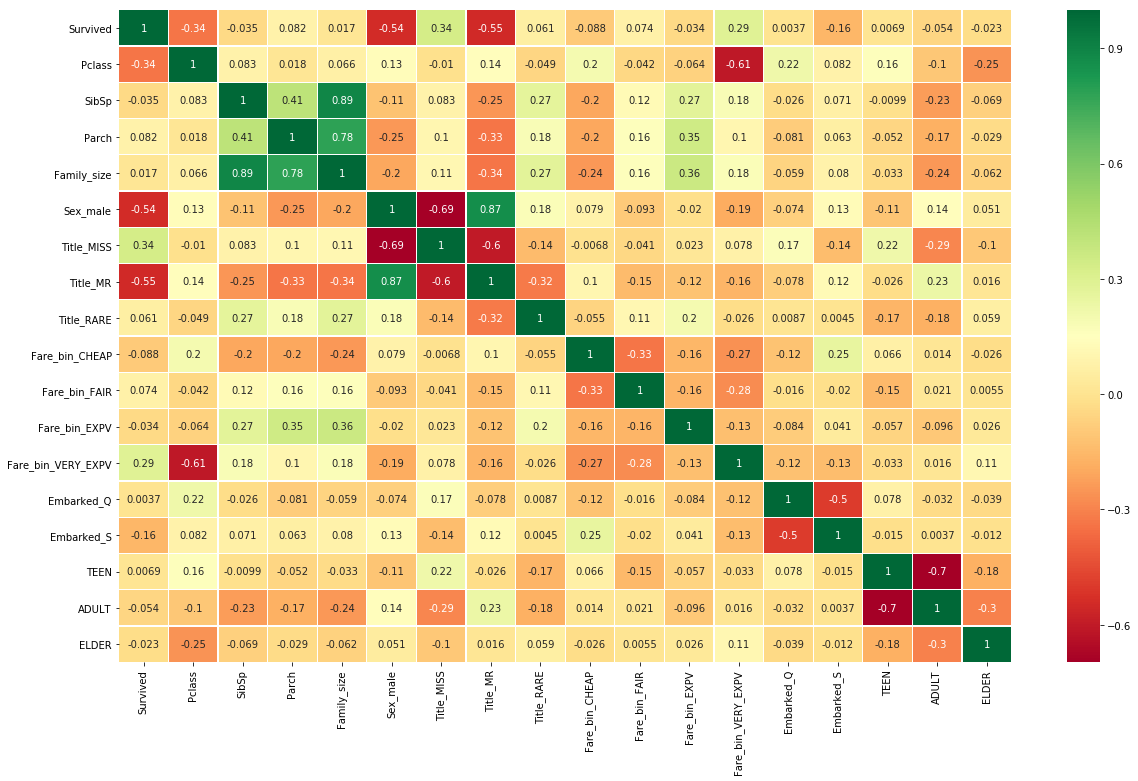

In [64]:
#heatmap 
sns.heatmap(train_df.corr(), annot=True, cmap='RdYlGn', linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

Interpreting The Heatmap The first thing to note is that only the numeric features are compared as it is obvious that we cannot correlate between alphabets or strings. Before understanding the plot, let us see what exactly correlation is.

POSITIVE CORRELATION: If an increase in feature A leads to increase in feature B, then they are positively correlated. A value 1 means perfect positive correlation.

NEGATIVE CORRELATION: If an increase in feature A leads to decrease in feature B, then they are negatively correlated. A value -1 means perfect negative correlation.

Now lets say that two features are highly or perfectly correlated, so the increase in one leads to increase in the other. This means that both the features are containing highly similar information and there is very little or no variance in information. This is known as MultiColinearity as both of them contains almost the same information.

So do you think we should use both of them as one of them is redundant. While making or training models, we should try to eliminate redundant features as it reduces training time and many such advantages.

Now from the above heatmap,we can see that the features are not much correlated. The highest correlation is between SibSp and Parch i.e 0.41. So we can carry on with all features.

## Model

Now we are ready to train a model and predict the required solution. There are lot of predictive modelling algorithms to choose from. We must understand the type of problem and solution requirement to narrow down to a select few models which we can evaluate. Our problem is a classification and regression problem. We want to identify relationship between output (Survived or not) with other variables or features (Gender, Age, Port...). We are also perfoming a category of machine learning which is called supervised learning as we are training our model with a given dataset. With these two criteria - Supervised Learning plus Classification and Regression, we can narrow down our choice of models to a few. These include:

Logistic Regression

KNN

Support Vector Machines

Naive Bayes classifier

Decision Tree

Random Forrest

Linear Discriminant Analysis

Ada Boost Classifier

Gradient Boosting Classifier

And also compared above given classifiers and evaluate the mean accuracy of each of them by a stratified kfold cross validation procedure and plot accuracy based confusion matrix

In [69]:
from sklearn.model_selection import train_test_split

#prepare train data for splitting
X = train_df.drop('Survived', axis=1)
y = train_df['Survived']

#traditional train-test-split
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.2, 
                                                  random_state=42)
print("Shape of trainables:", X_train.shape, y_train.shape)
print("Shape of validation dataset", X_val.shape, y_val.shape)

Shape of trainables: (712, 17) (712,)
Shape of validation dataset (179, 17) (179,)


## 2.1 Logistic Regression
Let's dive head first with Logistic Regression. Logistic (Regression) Classifier is only capable for binary classification. It's output is either zero or one.  

--------------The Accuracy of the model----------------------------
The accuracy of the Logistic Regression is 79.89
Cross-validated score of Logistic Regression model: 80.92


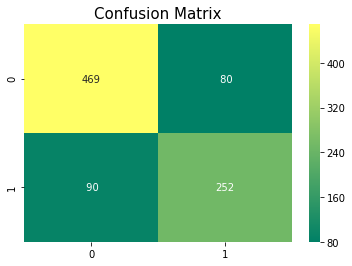

In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, 
                             confusion_matrix)

#Single hold-outs validation - using train_test_split
logReg_clf = LogisticRegression() #default hyper-param tuning
logReg_clf.fit(X_train, y_train)
y_pred = logReg_clf.predict(X_val)
score_logReg_single = round(accuracy_score(y_pred,y_val)*100, 2)

print("--------------The Accuracy of the model----------------------------")
print("The accuracy of the Logistic Regression is", score_logReg_single)

from sklearn.model_selection import (cross_val_score, 
                                     cross_val_predict)

#Cross validation
scores_logReg = cross_val_score(logReg_clf, X, y, cv=10, scoring='accuracy')
y_pred = cross_val_predict(logReg_clf, X, y, cv=10, n_jobs=4)
conf_mat = confusion_matrix(y, y_pred)

print("Cross-validated score of Logistic Regression model:", round(scores_logReg.mean()*100, 2))
sns.heatmap(conf_mat, annot=True, fmt='3.0f', cmap='summer')
plt.title('Confusion Matrix', y=1.05, size=15);

## 2.2 Random Forest Classifier

--------------The Accuracy of the model----------------------------
The accuracy of the Logistic Regression is 81.56
The Cross validation accuracy score of the Random Forest is 0.827199523323119


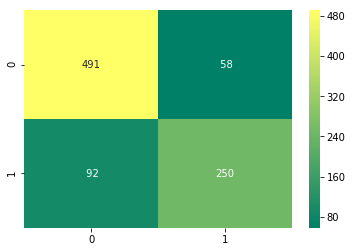

In [89]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, 
                            confusion_matrix)

#Single hold-outs validation
rforest_clf = RandomForestClassifier(n_estimators=100, max_depth=6, n_jobs=-1)
rforest_clf.fit(X_train, y_train)
y_pred = rforest_clf.predict(X_val)
score_rforest_single = round(accuracy_score(y_pred,y_val)*100, 2)

print("--------------The Accuracy of the model----------------------------")
print("The accuracy of the Logistic Regression is", score_rforest_single)

from sklearn.model_selection import (cross_val_score,
                                    cross_val_predict)
#Cross Validation
scores_rforest = cross_val_score(rforest_clf, X, y, cv=10, scoring='accuracy')
y_pred = cross_val_predict(rforest_clf, X, y, cv=10, n_jobs=-1)
conf_mat = confusion_matrix(y, y_pred)

print("The Cross validation accuracy score of the Random Forest is", scores_rforest.mean())
sns.heatmap(conf_mat, annot=True, cmap='summer', fmt='3.0f');

## 2.3 Support Vector Machine

--------------The Accuracy of the model----------------------------
The accuracy of the Logistic Regression is 81.01
The Cross validation accuracy score of the Random Forest is 82.26546362501418


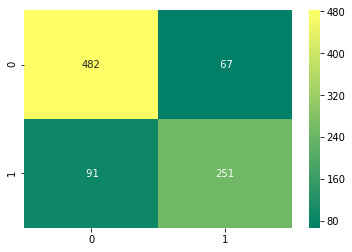

In [101]:
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, 
                            confusion_matrix)

#Single hold-outs validation
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_val)
score_svc_single = round(accuracy_score(y_pred,y_val)*100, 2)

print("--------------The Accuracy of the model----------------------------")
print("The accuracy of the Logistic Regression is", score_svc_single)

from sklearn.model_selection import (cross_val_score,
                                    cross_val_predict)
#Cross Validation
scores_svc = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
y_pred = cross_val_predict(svc, X, y, cv=10, n_jobs=-1)
conf_mat = confusion_matrix(y, y_pred)

print("The Cross validation accuracy score of the Random Forest is", scores_svc.mean()*100)
sns.heatmap(conf_mat, annot=True, cmap='summer', fmt='3.0f');

## Modularity in Data Science? Function.
Stop right there! We have been writing the same thing over and over again for different classifiers for three times in a go. Let's write a function instead to handle our reptitive work. 

```
    When you have answered the same question three times, write a blog.
    When you have writen the same code three times, write a function...
```

In [98]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import (train_test_split, 
                                     cross_val_predict, 
                                     cross_val_score)
#def function to get baseline scorings
def machine_learning(clf, X, y, name='Classifier'): #will do the train split test as well...
    #splitting - single holdout
    X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.2, 
                                                  random_state=69)
    #machine learning - single holdout
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    score_single = accuracy_score(y_val, y_pred)
    #print result
    print("--------------The Accuracy of the model----------------------------")
    print("The accuracy of the Logistic Regression is", score_single)
    
    #machine learning - cross validation
    scores_cv = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
    y_pred = cross_val_predict(clf, X, y, cv=10, n_jobs=-1)
    conf_mat = confusion_matrix(y, y_pred)
    score_cv = round(scores_cv.mean()*100, 2)
    #print & plot result
    print("The cross val accuracy of {} is {}".format(name, score_cv))
    sns.heatmap(conf_mat, cmap='summer', annot=True, fmt='3.0f')
    plt.title('Confusion Matrix')
    
    return score_single, score_cv, conf_mat

Let's continue... where were we?? Ah the Gausian Naive Bayes
## 2.4 Gaussian Naive Bayes 

--------------The Accuracy of the model----------------------------
The accuracy of the Logistic Regression is 0.8156424581005587
The cross val accuracy of Gaussian Naive Bayes is 78.8


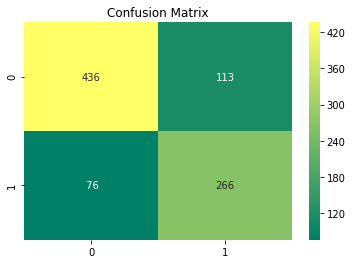

In [103]:
#Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
gaussian_nb = GaussianNB()
score_gnb, scorecv_gnb, conf_mat_gnb = machine_learning(gaussian_nb, X, y, name='Gaussian Naive Bayes') 

## 2.5 Linear Discriminant Analysis

--------------The Accuracy of the model----------------------------
The accuracy of the Logistic Regression is 0.8324022346368715
The cross val accuracy of Linear Discriminant Analysis is 80.47


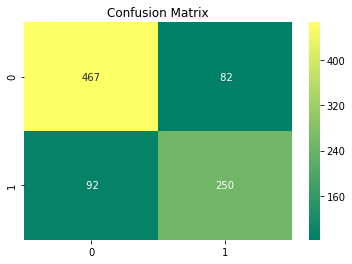

In [104]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
score_lda, scorecv_lda, conf_mat_lda = machine_learning(lda, X, y, name='Linear Discriminant Analysis')

## 2.6 Ada Boost Classifier
ABC stands for Ada Boost Classifier... interesting! We are going to use just one tree (Decision Tree Classifier) for baseline scoring. 

Hence this is more like Decision Tree + Adaptive Boosting. In fact Boosting alone can't be a classifier. It's job is to boost learners/classifier models.  

--------------The Accuracy of the model----------------------------
The accuracy of the Logistic Regression is 0.8324022346368715
The cross val accuracy of Adaptive Boosting Classifier is 81.81


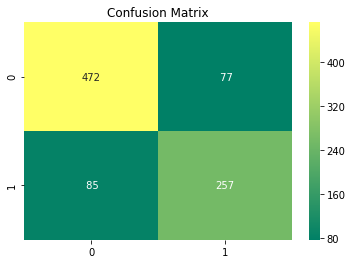

In [114]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), 
                         n_estimators=200, 
                         learning_rate=0.01)
score_abc, scorecv_abc, conf_mat_abc = machine_learning(abc, X, y, name='Adaptive Boosting Classifier')

## 2.7 Gradient Boosting Classifier

--------------The Accuracy of the model----------------------------
The accuracy of the Logistic Regression is 0.8100558659217877
The cross val accuracy of Gradient Boosting Classifier is 82.27


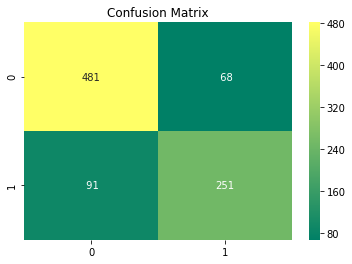

In [126]:
from sklearn.ensemble import GradientBoostingClassifier
gbm = GradientBoostingClassifier(n_estimators=100, 
                                 learning_rate=0.05, 
                                 subsample=0.6, 
                                 max_depth=2)
score_gbm, scorecv_gbm, conf_mat_gbm = machine_learning(gbm, X, y, name='Gradient Boosting Classifier')

In [134]:
models_score = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'SVM Classifier', 'GNaive Bayes', 
              'Linear Discriminant Analysis', 'Adaptive Boost', 'Gradient Boosting'],
    'Score': [scores_logReg.mean()*100, scores_rforest.mean()*100, scores_svc.mean()*100, scorecv_gnb, 
              scorecv_lda, scorecv_abc, scorecv_gbm]
})
models_score.sort_values(by=['Score', 'Model'], ascending=False)

,Model,Score
1,Random Forest,82.719952
6,Gradient Boosting,82.270000
2,SVM Classifier,82.265464
5,Adaptive Boost,81.810000
0,Logistic Regression,80.917064
4,Linear Discriminant Analysis,80.470000
3,GNaive Bayes,78.800000


By looking at the table of models scores, we can say that **Random Forest Classifier**, **Gradient Boosting Classifier**, and **SVM Classifier** have better performance.

# 3. Hyper-Parameter Tuning

The machine learning models are like a Black-Box. There are some default parameter values for this Black-Box, which we can tune or change the learning rate of the algorithm and get a better model. This is known as Hyper-Parameter Tuning

So based on the above given acuracy result i will performance Grid search and random search for the SVM, LDA, Logistic Regression, Gradient Decent Classifier, Random Forest Classifier.

Just a quick lookup, the parameters that we will be playing with are listed here.

- n_jobs : Number of cores used for the training process. If set to -1, all cores are used.

- n_estimators : Number of classification trees in your learning model ( set to 10 per default)

- max_depth : Maximum depth of tree, or how much a node should be expanded. Beware if set to too high a number would run the risk of overfitting as one would be growing the tree too deep

- verbose : Controls whether you want to output any text during the learning process. A value of 0 suppresses all text while a value of 3 outputs the tree learning process at every iteration.

Please check out the full description via the official Sklearn website. There you will find that there are a whole host of other useful parameters that you can play around with.

In [138]:
#rearrange our dataset for real training and test(submission)
X_train = train_df.drop('Survived', axis=1)
y_train = train_df['Survived']
X_test = test_df

print("Shape of training dataset:", X_train.shape, y_train.shape)
print("Shape of test dataset:", X_test.shape)

Shape of training dataset: (891, 17) (891,)
Shape of test dataset: (418, 17)


,Pclass,SibSp,Parch,Family_size,Sex_male,Title_MISS,Title_MR,Title_RARE,Fare_bin_CHEAP,Fare_bin_FAIR,Fare_bin_EXPV,Fare_bin_VERY_EXPV,Embarked_Q,Embarked_S,TEEN,ADULT,ELDER
0,3,0,0,1,1,0,1,0,0,0,0,0,1,0,0,1,0
1,3,1,0,2,0,0,0,0,0,0,0,0,0,1,0,1,0
2,2,0,0,1,1,0,1,0,1,0,0,0,1,0,0,0,1
3,3,0,0,1,1,0,1,0,1,0,0,0,0,1,0,1,0
4,3,1,1,3,0,0,0,0,1,0,0,0,0,1,1,0,0


In [136]:
from sklearn.model_selection import GridSearchCV

params_gbm = {
    'loss': ['deviance', 'exponential'],
    'learning_rate': [0.01, 0.001, 0.01],
    'n_estimators': [200, 500, 1000],
    'subsample': [0.5, 0.7, 1.0],
    'max_depth': [3, 4, 5, 7],
    'max_features': ['sqrt', 'log2', None],
}

params_abc = {
    'n_estimators': [200, 500, 1000],
    'learning_rate': [0.1, 0.01, 0.001],
    'algorithm': ['SAMME', 'SAMME.R']
}

params_rforest = {
    'n_estimators': [200, 500, 1000],
    'max_depth': [None, 3, 5, 8],
    'max_features': ['sqrt', 'log2', None],
    'n_jobs': [-1],
    'oob_score': [True],
}

params_lda = {
    'solver': ['lsqr', 'eigen'],
    'shrinkage': ['auto']
}

params_svc = {
    'kernel': ['rbf', 'poly', 'linear'],
    'gamma': [0, 1, 100, 10000],
    'C': [1, 100, 10000]
}

## 3.1 Gradient Boosting Tuning

In [139]:
#Gradient Boosting Hyper-params tuning
from sklearn.ensemble import GradientBoostingClassifier
gbm_clf = GradientBoostingClassifier()
gscv_gbm = GridSearchCV(gbm_clf, params_gbm, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
gscv_gbm.fit(X_train, y_train)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed: 12.3min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'loss': ['deviance', 'exponential'], 'learning_rate': [0.01, 0.001, 0.01], 'n_estimators': [200, 500, 1000], 'subsample': [0.5, 0.7, 1.0], 'max_depth': [3, 4, 5, 7], 'max_features': ['sqrt', 'log2', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [140]:
#best hyper-params
gbm_bparams = gscv_gbm.best_params_
#best score
gbm_bscore = gscv_gbm.best_score_
#best estimator
gbm_best = gscv_gbm.best_estimator_

print("The best GBM hyper-parameter tuning:", gbm_bparams)
print("The best GBM cross validation scores:", gbm_bscore)

The best GBM hyper-parameter tuning: {'learning_rate': 0.001, 'loss': 'exponential', 'max_depth': 3, 'max_features': None, 'n_estimators': 1000, 'subsample': 1.0}
The best GBM cross validation scores: 0.8271604938271605


## 3.2 Support Vector Machine

In [ ]:
#SVC Hyper-params tuning
from sklearn.svm import SVC
svc = SVC()
gscv_svc = GridSearchCV(svc, params_svc, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
gscv_svc.fit(X_train, y_train)

In [ ]:
#best hyper-params
svc_bparams = gscv_svc.best_params_
#best score
svc_bscore = gscv_svc.best_score_
#best estimator
svc_best = gscv_svc.best_estimator_

print("The best SVC hyper-parameter tuning:", svc_bparams)
print("The best SVC cross validation scores:", svc_bscore)

## 3.3 Random Forest Classifier

In [ ]:
#Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rforest_clf = RandomForestClassifier()
gscv_rf = GridSearchCV(rforest_clf, params_rforest, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
gscv_rf.fit(X_train, y_train)

In [ ]:
#best hyper-params
rf_bparams = gscv_rf.best_params_
#best score
rf_bscore = gscv_rf.best_score_
#best estimator
rf_best = gscv_rf.best_estimator_
print("The best SVC hyper-parameter tuning:", rf_bparams)
print("The best SVC cross validation scores:", rf_bscore)

## 3.4 Adaptive Boosting Classifier
With previous top classifier as base estimator/learner

In [ ]:
#ensure the above 3.1 - 3.3 has finished running
params_abc['base_estimator'] = [rf_best, svc_best, gbm_best]

In [ ]:
#Adaboost Classifier
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier()
gscv_abc = GridSearchCV(abc, params_abc, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
gscv_abc.fit(X_train, y_train)

In [ ]:
#best hyper-params
abc_bparams = gscv_abc.best_params_
#best score
abc_bscore = gscv_abc.best_score_
#best estimator
abc_best = gscv_abc.best_estimator_

print("The best SVC hyper-parameter tuning:", abc_bparams)
print("The best SVC cross validation scores:", abc_bscore)

## 3.5 Linear Discriminant Classifier

In [ ]:
#LDA Classifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
gscv_lda = GridSearchCV(lda, params_lda, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
gscv_lda.fit(X_train, y_train)

In [ ]:
#best hyper-params
lda_bparams = gscv_lda.best_params_
#best score
lda_bscore = gscv_lda.best_score_
#best estimator
lda_best = gscv_lda.best_estimator_

print("The best SVC hyper-parameter tuning:", lda_bparams)
print("The best SVC cross validation scores:", lda_bscore)